In [40]:
#import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PowerTransformer




from import_merged import NEW_FEATURES


,Anlieferungsdatum,Material,Gewicht in Tonnen,Day,Workday,Total Pedestrians,Location,Temperature mean,Temperature max,Temperature min,Precipitation in mm,Snow amount in cm,Total Costs
0,2021-09-20,Inertstoffe,3.14,-1.422622,0.054705,0.080286,St. Gallen,0.079766,-0.145984,0.368845,0.766344,-0.447039,-0.400199
1,2021-09-20,stark verschmutzte Abfälle,21.04,-1.422622,0.054705,0.080286,St. Gallen,0.079766,-0.145984,0.368845,0.766344,-0.447039,-0.400199
2,2021-09-20,stark verschmutzte Abfälle,22.00,-1.422622,0.054705,0.080286,St. Gallen,0.079766,-0.145984,0.368845,0.766344,-0.447039,-0.400199
3,2021-09-20,stark verschmutzte Abfälle,8.12,-1.422622,0.054705,0.080286,St. Gallen,0.079766,-0.145984,0.368845,0.766344,-0.447039,-0.400199
4,2021-09-20,Inertstoffe,3.38,-1.422622,0.054705,0.080286,St. Gallen,0.079766,-0.145984,0.368845,0.766344,-0.447039,-0.400199


In [25]:
#for time-series random forest you need to lag features and target to preserve temporal order 
def create_lagged_features(df, target_column, lags):
    lagged_df = pd.DataFrame()
    for lag in range(1, lags + 1):
        for col in df.columns:
            lagged_df[f'{col}_lag_{lag}'] = df[col].shift(lag)
    lagged_df[target_column] = df[target_column]  # Keep the target variable
    return lagged_df

# Generate lagged features
#afterwards test for optimal lags
lags = 3  # Use 3 lag steps
lagged_data = create_lagged_features(NEW_FEATURES, 'Gewicht in Tonnen', lags)

# Drop NaN values caused by lagging
lagged_data = lagged_data.dropna()

In [39]:
# Define features and target

# Define the target variable
target = 'Gewicht in Tonnen'

# Define the features
features = ['Day', 'Workday', 'Total Pedestrians', 'Temperature mean', 'Temperature max', 'Temperature min', 'Precipitation in mm', 'Snow amount in cm', 'Total Costs']

# Split the data into features (X) and target (y)
X = NEW_FEATURES[features]
y = NEW_FEATURES[target]



In [27]:


#define number of estimators
B=100

# Define the number of splits for rolling cross-validation
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store mean squared errors
mse_train_list = []
mse_test_list = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Create and train the decision tree regressor
    tree_regressor = DecisionTreeRegressor(random_state=42)
    tree_regressor.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = tree_regressor.predict(X_train)
    y_test_pred = tree_regressor.predict(X_test)
    
    # Evaluate the model
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    
    mse_train_list.append(mse_train)
    mse_test_list.append(mse_test)

# Calculate the average mean squared error for train and test sets
avg_mse_train = np.mean(mse_train_list)
avg_mse_test = np.mean(mse_test_list)

print(f'Average Mean Squared Error for the decision tree (train): {avg_mse_train}')
print(f'Average Mean Squared Error for the decision tree (test): {avg_mse_test}')

# Plot the decision tree
# plt.figure(figsize=(20,10))
# plot_tree(tree_regressor, filled=True, feature_names=X_train.columns, rounded=True)
# plt.show()

# Initialize lists to store mean squared errors for random forest
mse_train_rf_list = []
mse_test_rf_list = []

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Create and train the random forest regressor
    rf_regressor = RandomForestRegressor(n_estimators=B, random_state=42)
    rf_regressor.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred_rf = rf_regressor.predict(X_train)
    y_test_pred_rf = rf_regressor.predict(X_test)
    
    # Evaluate the model
    mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
    mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
    
    mse_train_rf_list.append(mse_train_rf)
    mse_test_rf_list.append(mse_test_rf)

# Calculate the average mean squared error for train and test sets
avg_mse_train_rf = np.mean(mse_train_rf_list)
avg_mse_test_rf = np.mean(mse_test_rf_list)

print(f'Average Mean Squared Error for the random forest (train): {avg_mse_train_rf}')
print(f'Average Mean Squared Error for the random forest (test): {avg_mse_test_rf}')

Average Mean Squared Error for the decision tree (train): 54.98985036410535
Average Mean Squared Error for the decision tree (test): 57.12991570683473
Average Mean Squared Error for the random forest (train): 55.007948821411425
Average Mean Squared Error for the random forest (test): 55.71942100236771


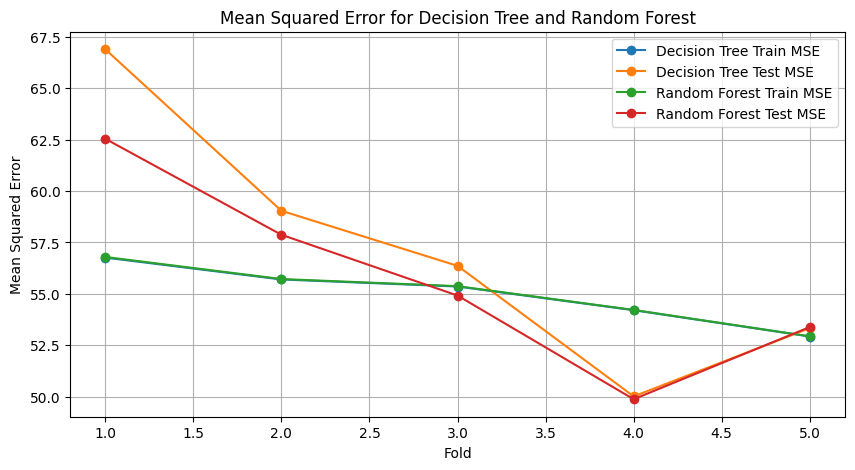

In [23]:
# Plotting the MSE for Decision Tree and Random Forest
plt.figure(figsize=(10, 5))

# Plot MSE for Decision Tree
plt.plot(range(1, n_splits + 1), mse_train_list, marker='o', label='Decision Tree Train MSE')
plt.plot(range(1, n_splits + 1), mse_test_list, marker='o', label='Decision Tree Test MSE')

# Plot MSE for Random Forest
plt.plot(range(1, n_splits + 1), mse_train_rf_list, marker='o', label='Random Forest Train MSE')
plt.plot(range(1, n_splits + 1), mse_test_rf_list, marker='o', label='Random Forest Test MSE')

plt.xlabel('Fold')
plt.ylabel('Mean Squared Error')
plt.title('Mean Squared Error for Decision Tree and Random Forest')
plt.legend()
plt.grid(True)
plt.show()